Imports

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

Read data

In [5]:
data = pd.read_csv("selected_data.csv")

- Data transformation

In [6]:
data.head()

,make,fuel-type,aspiration,body-style,drive-wheels,engine-type,fuel-system,curb-weight,power-weight,price
0,audi,gas,std,sedan,fwd,ohc,mpfi,2337,22.9,13950
1,audi,gas,std,sedan,4wd,ohc,mpfi,2824,24.6,17450
2,audi,gas,std,sedan,fwd,ohc,mpfi,2844,25.9,17710
3,audi,gas,turbo,sedan,fwd,ohc,mpfi,3086,22.0,23875
4,bmw,gas,std,sedan,rwd,ohc,mpfi,2395,23.7,16430


In [7]:
# apply One-Hot Encoding to the categorical columns
columns_to_encode = ['make', 'fuel-type', 'aspiration', 'body-style', 'drive-wheels', 'engine-type', 'fuel-system']
data = pd.get_dummies(data, columns=columns_to_encode) 

In [8]:
data.head()

,curb-weight,power-weight,price,make_audi,make_bmw,make_chevrolet,make_dodge,make_honda,make_jaguar,make_mazda,...,engine-type_ohcf,engine-type_ohcv,engine-type_rotor,fuel-system_1bbl,fuel-system_2bbl,fuel-system_4bbl,fuel-system_idi,fuel-system_mfi,fuel-system_mpfi,fuel-system_spdi
0,2337,22.9,13950,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,2824,24.6,17450,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,2844,25.9,17710,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,3086,22.0,23875,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,2395,23.7,16430,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [9]:
# turn booleans to numeric type
def replace_boolean(df):
    for col in df.columns:
        if df[col].dtype == 'bool':
            df[col] = df[col].astype(int)
    return df

In [10]:
data = replace_boolean(data)

- Data processing

- Split data into training and testing set

In [11]:
# features
X = data.drop('price', axis=1)
# target
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=42)

- Ordinary Least Squares (OLS)

In [12]:
'''
- high R-squared - the target is well influenced by the features
- there are some features that have a high p-value as a p-value criterion it is understood that these columns 
doesn't influence the target
'''
X = sm.add_constant(X)
model = sm.OLS(y,X) 
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     86.69
Date:                Sun, 29 Oct 2023   Prob (F-statistic):           8.44e-74
Time:                        00:34:51   Log-Likelihood:                -1404.5
No. Observations:                 165   AIC:                             2883.
Df Residuals:                     128   BIC:                             2998.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -253

- Models training and Performance Metrics

In [113]:
def evaluate_models(models, X_train, X_test, y_train, y_test):    
    results = {}
    trained_models = {}

    # training models
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        cv = cross_val_score(model, X_train, y_train, cv=10)
        cv = cv.mean()
        results[model_name] = {"MAE": mae, "R²": r2, "CV": cv}
        trained_models[model_name] = model
    return results, trained_models

- Baseline

In [35]:
# models 
models = {
    "Linear Regression": LinearRegression(),
    "CatBoost Regressor": CatBoostRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
}

results, models = evaluate_models(models, X_train, X_test, y_train, y_test)

Learning rate set to 0.029732
0:	learn: 6191.4267651	total: 1.13ms	remaining: 1.13s
1:	learn: 6094.4509580	total: 2.03ms	remaining: 1.01s
2:	learn: 5983.4220573	total: 3.06ms	remaining: 1.02s
3:	learn: 5891.5429228	total: 4.09ms	remaining: 1.02s
4:	learn: 5791.1927218	total: 4.69ms	remaining: 933ms
5:	learn: 5696.7146412	total: 5.68ms	remaining: 941ms
6:	learn: 5608.7507852	total: 6.67ms	remaining: 947ms
7:	learn: 5534.5479256	total: 7.92ms	remaining: 982ms
8:	learn: 5443.8037526	total: 8.88ms	remaining: 977ms
9:	learn: 5354.4221852	total: 10.5ms	remaining: 1.04s
10:	learn: 5273.0775708	total: 12ms	remaining: 1.08s
11:	learn: 5200.5648672	total: 13.2ms	remaining: 1.09s
12:	learn: 5127.3018488	total: 14.5ms	remaining: 1.1s
13:	learn: 5050.8326301	total: 15.8ms	remaining: 1.11s
14:	learn: 4976.3860399	total: 16.7ms	remaining: 1.1s
15:	learn: 4909.8937030	total: 18.2ms	remaining: 1.12s
16:	learn: 4827.1791061	total: 19.5ms	remaining: 1.13s
17:	learn: 4739.3967163	total: 20.8ms	remaining: 

In [36]:
# print results
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"MAE: {metrics['MAE']:.2f}")
    print(f"R²: {metrics['R²']:.2f}")
    print(f"CV: {metrics['CV']:.2f}")
    print()

Model: Linear Regression
MAE: 996.45
R²: 0.94
CV: 0.86

Model: CatBoost Regressor
MAE: 932.23
R²: 0.94
CV: 0.85

Model: Random Forest Regressor
MAE: 1295.21
R²: 0.86
CV: 0.85



In [89]:
# compare errors with descriptive statistics 
statistics = data["price"].describe()
statistics

count      165.000000
mean     11612.478788
std       6081.970725
min       5118.000000
25%       7463.000000
50%       9279.000000
75%      15040.000000
max      35550.000000
Name: price, dtype: float64

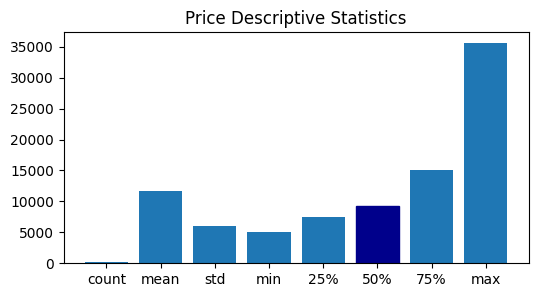

In [108]:
# plot descriptive statistics
plt.figure(figsize=(6, 3))
bars = plt.bar(statistics.index, statistics.values)
index_median = statistics.index.get_loc('50%')
bars[index_median].set_color('darkblue')
plt.title('Price Descriptive Statistics')
plt.show()

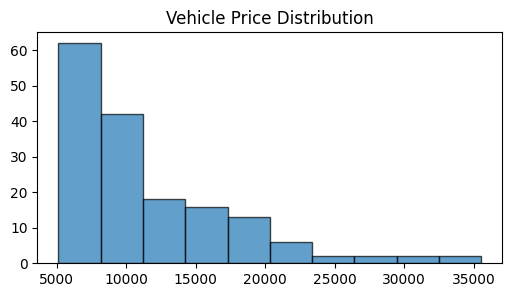

In [109]:
# price histogram
plt.figure(figsize=(6, 3)) 
plt.hist(data['price'], edgecolor='black', alpha=0.7)
plt.title('Vehicle Price Distribution')
plt.grid(False) 
plt.show()

- Hyperparameter Optimization Technique - GridSearch

- Apply parameter optimization with CatBoost Regressor and Random Forest Regressor because they were the best and worst model in relation to the baseline result

- CatBoost Regressor

In [46]:
def catboost_grid_search(X_train, X_test, y_train, y_test):
    model = CatBoostRegressor()

    param_grid = {
        'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]
    }

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=8, scoring='neg_mean_absolute_error')
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print("Best parameters for CatBoost Regressor:", best_params)

    # Performance metrics
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rounded_mae = round(mae, 2)
    r2 = r2_score(y_test, y_pred)
    rounded_r2 = round(r2, 2)
    print(f"Mean Absolute Error (MAE) in test set - CatBoost Regressor: {rounded_mae}")
    print(f"R squared (R²) in test set - CatBoost Regressor: {rounded_r2}")

    return best_params, rounded_mae, rounded_r2, best_model


In [47]:
best_params, mae, r2, model = catboost_grid_search(X_train, X_test, y_train, y_test)

0:	learn: 6391.1133776	total: 1.42ms	remaining: 141ms
1:	learn: 6239.4789078	total: 2.84ms	remaining: 139ms
2:	learn: 6088.3842075	total: 4.02ms	remaining: 130ms
3:	learn: 5945.8036925	total: 5.3ms	remaining: 127ms
4:	learn: 5827.4647567	total: 5.97ms	remaining: 113ms
5:	learn: 5696.2653957	total: 7.14ms	remaining: 112ms
6:	learn: 5559.4626838	total: 8.36ms	remaining: 111ms
7:	learn: 5436.1305550	total: 10.1ms	remaining: 116ms
8:	learn: 5319.8974336	total: 11ms	remaining: 112ms
9:	learn: 5217.4839132	total: 12.2ms	remaining: 110ms
10:	learn: 5117.9549850	total: 13.6ms	remaining: 110ms
11:	learn: 5007.0402615	total: 14.8ms	remaining: 109ms
12:	learn: 4918.0378505	total: 16ms	remaining: 107ms
13:	learn: 4807.5820383	total: 17.3ms	remaining: 106ms
14:	learn: 4696.6311597	total: 18.8ms	remaining: 107ms
15:	learn: 4598.9485765	total: 20.4ms	remaining: 107ms
16:	learn: 4498.7546320	total: 21.6ms	remaining: 106ms
17:	learn: 4405.6211465	total: 22.8ms	remaining: 104ms
18:	learn: 4348.2836305	t

Text(0.5, 0, 'CatBoost Feature Importance')

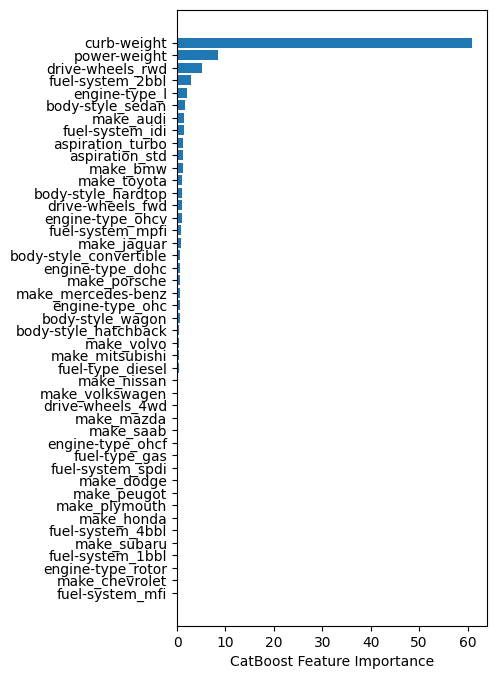

In [60]:
# extract festures importance
sorted_feature_importance = model.feature_importances_.argsort()
plt.figure(figsize=(4,8))
plt.barh(X_train.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance]
        )
plt.xlabel("CatBoost Feature Importance")

- Random Forest Regressor

In [61]:
def random_forest_grid_search(X_train, X_test, y_train, y_test):
    model = RandomForestRegressor()

    param_grid = {
        'n_estimators': [50, 100, 200],
        'bootstrap': [True,False],
        'max_depth': [None, 10, 20, 50, 75],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 10, 20],
        'max_features': [None, 1], 
        'oob_score': [True,False],
    }
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=8, scoring='neg_mean_absolute_error')
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print("Best parameters for Random Forest Regressor:", best_params)

    # Performance metrics
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rounded_mae = round(mae, 2)
    r2 = r2_score(y_test, y_pred)
    rounded_r2 = round(r2, 2)
    print(f"Mean Absolute Error (MAE) in test set - Random Forest Regressor: {rounded_mae}")
    print(f"R squared (R²) in test set - Random Forest Regressor: {rounded_r2}")

    return best_params, rounded_mae, rounded_r2, best_model

In [62]:
best_params, mae, r2, model = random_forest_grid_search(X_train, X_test, y_train, y_test)

Best parameters for Random Forest Regressor: {'bootstrap': True, 'max_depth': 50, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'oob_score': False}
Mean Absolute Error (MAE) in test set - Random Forest Regressor: 1298.35
R squared (R²) in test set - Random Forest Regressor: 0.85


- Models training with optimized parameters

In [ ]:
# for use in the cat_features parameter in CatBoost Regressor
binary_columns = [col for col in X_train.columns if set(X_train[col]) == {0, 1}]

In [114]:
# models - with updated parameters
models = {
    "CatBoost Regressor": CatBoostRegressor(iterations=150,learning_rate=0.1,l2_leaf_reg= 0.2, cat_features=binary_columns),
    "Random Forest Regressor": RandomForestRegressor(max_depth=50, max_features=None, n_estimators=200),
}

results, models = evaluate_models(models, X_train, X_test, y_train, y_test)

0:	learn: 5893.6896556	total: 10.7ms	remaining: 1.59s
1:	learn: 5511.8329440	total: 12.8ms	remaining: 945ms
2:	learn: 5096.2317386	total: 14.2ms	remaining: 697ms
3:	learn: 4778.6408362	total: 15.1ms	remaining: 553ms
4:	learn: 4476.0689235	total: 15.8ms	remaining: 458ms
5:	learn: 4226.4431360	total: 17ms	remaining: 407ms
6:	learn: 3995.8243479	total: 18.1ms	remaining: 370ms
7:	learn: 3759.9405607	total: 19.3ms	remaining: 342ms
8:	learn: 3554.6352791	total: 20.3ms	remaining: 319ms
9:	learn: 3351.2195044	total: 21.6ms	remaining: 302ms
10:	learn: 3153.8557194	total: 23.3ms	remaining: 295ms
11:	learn: 2960.9924091	total: 25.1ms	remaining: 288ms
12:	learn: 2786.6078602	total: 26.6ms	remaining: 280ms
13:	learn: 2644.0033546	total: 28.1ms	remaining: 273ms
14:	learn: 2543.7825234	total: 29.5ms	remaining: 266ms
15:	learn: 2412.2125341	total: 31.1ms	remaining: 261ms
16:	learn: 2310.9971775	total: 32.6ms	remaining: 255ms
17:	learn: 2202.1647163	total: 33.9ms	remaining: 248ms
18:	learn: 2108.835504

In [117]:
# new results
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"MAE: {metrics['MAE']:.2f}")
    print(f"R²: {metrics['R²']:.2f}")
    print(f"CV: {metrics['CV']:.2f}")
    print()

Model: CatBoost Regressor
MAE: 769.06
R²: 0.96
CV: 0.85

Model: Random Forest Regressor
MAE: 1347.73
R²: 0.85
CV: 0.86



In [122]:
models

{'CatBoost Regressor': <catboost.core.CatBoostRegressor at 0x26212194370>,
 'Random Forest Regressor': RandomForestRegressor(max_depth=50, max_features=None, n_estimators=200)}

In [120]:
# get CatBoost model
next(iter(models.values()))

In [118]:
# save model
def save_model(model, file_name):
    
    joblib.dump(model, file_name)  # Create file with model 
      
    return model

In [123]:
file_name = "{}.pkl".format('catboost') 
save_model(next(iter(models.values())), file_name)

Final notes

- After updating the parameters CatBoost Regressor had the best performance with the parameters ('iterations': 150, 'l2_leaf_reg': 0.2, 'learning_rate': 0.1, cat_features=binary_columns) which is capable of predicting 96% of the variability in Automobile dataset prices with an MAE of about 769.

- Which showed us through the feature importances plot that the most influential variable in the model is curb-weight.

In [110]:
# save trained data to csv file
data.to_csv('trained_data.csv', index=False)